<a href="https://colab.research.google.com/github/karaage0703/karaage-ai-book/blob/master/ch02/02_karaage_ai_book_image_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像分類（PyTorch版）



## 教師データのダウンロード

ジャンケンの手の形の教師データをGitHubからダウンロード（Clone）します。

2,3行目はダウンロードしたデータから、使用するデータ以外の不要なファイルを削除しています。

教師データをダウンロードして、不要なファイルを削除します。

In [ ]:
!git clone https://github.com/karaage0703/janken_dataset original_datasets
!rm -rf /content/original_datasets/.git
!rm /content/original_datasets/LICENSE

Cloning into 'original_datasets'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 4.60 MiB | 36.21 MiB/s, done.
Resolving deltas: 100% (3/3), done.


データの中身の確認

In [ ]:
!ls original_datasets

choki  gu  pa


In [ ]:
!ls original_datasets/choki

choki_01.jpg  IMG_0783.JPG  IMG_0797.JPG  IMG_0811.JPG	IMG_0876.JPG
IMG_0770.JPG  IMG_0784.JPG  IMG_0798.JPG  IMG_0812.JPG	IMG_0877.JPG
IMG_0771.JPG  IMG_0785.JPG  IMG_0799.JPG  IMG_0813.JPG	IMG_0878.JPG
IMG_0772.JPG  IMG_0786.JPG  IMG_0800.JPG  IMG_0814.JPG	IMG_0879.JPG
IMG_0773.JPG  IMG_0787.JPG  IMG_0801.JPG  IMG_0815.JPG	IMG_0880.JPG
IMG_0774.JPG  IMG_0788.JPG  IMG_0802.JPG  IMG_0816.JPG	IMG_0881.JPG
IMG_0775.JPG  IMG_0789.JPG  IMG_0803.JPG  IMG_0817.JPG	IMG_0882.JPG
IMG_0776.JPG  IMG_0790.JPG  IMG_0804.JPG  IMG_0818.JPG	IMG_0883.JPG
IMG_0777.JPG  IMG_0791.JPG  IMG_0805.JPG  IMG_0870.JPG	IMG_0884.JPG
IMG_0778.JPG  IMG_0792.JPG  IMG_0806.JPG  IMG_0871.JPG	IMG_0885.JPG
IMG_0779.JPG  IMG_0793.JPG  IMG_0807.JPG  IMG_0872.JPG
IMG_0780.JPG  IMG_0794.JPG  IMG_0808.JPG  IMG_0873.JPG
IMG_0781.JPG  IMG_0795.JPG  IMG_0809.JPG  IMG_0874.JPG
IMG_0782.JPG  IMG_0796.JPG  IMG_0810.JPG  IMG_0875.JPG


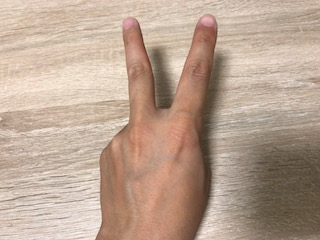

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import display_jpeg
display_jpeg(IPImage('original_datasets/choki/choki_01.jpg'))

## 教師データを訓練データ（Train Data）とテストデータ（Validation Data）に分ける

ディレクトリの構造を可視化するための'tree'というソフトをインストールします。

In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (868 kB/s)
Selecting previously unselected package tree.
(Reading database ... 145118 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!tree -d /content/original_datasets

/content/original_datasets
├── choki
├── gu
└── pa

3 directories


教師データのディレクトリと、ターゲットとなるディレクトリ（この下に訓練データのディレクトリと検証データのディレクトリが生成される）を指定。

In [ ]:
dataset_original_dir = '/content/original_datasets'
dataset_root_dir = '/content/datasets'

In [ ]:
!wget https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py

--2020-03-11 13:08:24--  https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/split_train_val.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2720 (2.7K) [text/plain]
Saving to: ‘split_train_val.py’

split_train_val.py  100%[===================>]   2.66K  --.-KB/s    in 0s      

2020-03-11 13:08:24 (61.8 MB/s) - ‘split_train_val.py’ saved [2720/2720]



In [ ]:
import split_train_val

In [ ]:
split_train_val.image_dir_train_val_split(dataset_original_dir, dataset_root_dir, train_size=0.66)

/content/original_datasets/choki copy is done
/content/original_datasets/gu copy is done
/content/original_datasets/pa copy is done
processing is done


In [ ]:
!tree -d /content/datasets

/content/datasets
├── train
│   ├── choki
│   ├── gu
│   └── pa
└── val
    ├── choki
    ├── gu
    └── pa

8 directories


In [ ]:
train_dir = '/content/datasets/train'
val_dir = '/content/datasets/val'

### データのロード

必要なライブラリをインポートします

当然今回はPyTorchです。合わせて、torchvision というデータの前処理や可視化をしてくれる便利なライブラリもインポートします。

In [ ]:
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

ImageFolderを使って、訓練ディレクトリの画像をdataset_train、検証ディレクトリの画像を dataset_valとして読み込みます

In [ ]:
dataset_train = datasets.ImageFolder(root=train_dir)
dataset_val = datasets.ImageFolder(root=val_dir)

dataset_trainとdataset_valの中身を確認します。それぞれ 109と58のデータが格納されていることが分かります。

In [ ]:
print(dataset_train)
print(dataset_val)

Dataset ImageFolder
    Number of datapoints: 109
    Root location: /content/datasets/train
Dataset ImageFolder
    Number of datapoints: 58
    Root location: /content/datasets/val


dataset_train[0]〜dataset_train[108]の中身は、PIL形式の画像データとラベルのインデックスが格納されています。

In [ ]:
x, y = dataset_train[0]
print(x)
print(y)
x, y = dataset_val[0]
print(x)
print(y)

<PIL.Image.Image image mode=RGB size=320x240 at 0x7F9C2C6204A8>
0
<PIL.Image.Image image mode=RGB size=320x240 at 0x7F9BCF5145F8>
0


具体的な中身は`__getitem__`で確認できます。

最後の数字はラベルを示しています。最初に表示させたディレクトリの表示順となり以下となります。

```
0: choki
1: gu
2: pa
```

In [ ]:
print(dataset_train.__getitem__(0))
print(dataset_train.__getitem__(50))
print(dataset_train.__getitem__(100))

(<PIL.Image.Image image mode=RGB size=320x240 at 0x7F9C3AE4F160>, 0)
(<PIL.Image.Image image mode=RGB size=320x240 at 0x7F9C26A565C0>, 1)
(<PIL.Image.Image image mode=RGB size=320x240 at 0x7F9C3AE4F160>, 2)


matplotlibで中身を確認してみましょう。

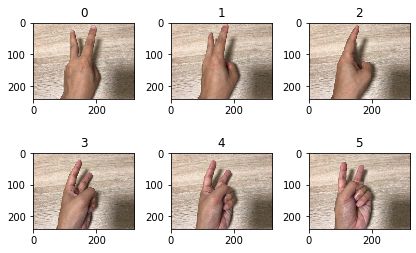

In [ ]:
image_numb = 6 # 3の倍数を指定してください
for i in range(0, image_numb):
  ax = plt.subplot(image_numb / 3, 3, i + 1)
  plt.tight_layout()
  ax.set_title(str(i))
  plt.imshow(dataset_train[i][0])

datasetは使えるようになりましたが、PyTorchで扱うためにサイズの変換と、テンソル化というPyTorch等のディープラーニングのフレームワークで多く使われる、Tensor形式に変換する必要があります。

具体的には、transforms機能を用いて、以下の前処理を実施します。
- リサイズ(transforms.Resize())
- テンソル化(transforms.ToTensor())

以下のように書くと、前処理を実施したデータが読み込めます

参考： https://qiita.com/kazetof/items/6a72926b9f8cd44c218e

In [ ]:
IMAGE_SIZE = 64
data_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

dataset_train = datasets.ImageFolder(root=train_dir, transform=data_transform)
dataset_val = datasets.ImageFolder(root=val_dir, transform=data_transform)

中身を確認します。前処理情報が追記されています。

In [ ]:
print(dataset_train)
print(dataset_val)

Dataset ImageFolder
    Number of datapoints: 109
    Root location: /content/datasets/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 58
    Root location: /content/datasets/val
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


生の値を確認しましょう。教師データのPIL形式の画像が、テンソル形式に変換され、値の範囲が0〜1になっていることが分かります。

In [ ]:
print(dataset_train.__getitem__(0))

(tensor([[[0.9059, 0.9020, 0.9098,  ..., 0.7647, 0.7765, 0.8039],
         [0.9059, 0.9020, 0.9020,  ..., 0.7804, 0.7725, 0.7804],
         [0.8902, 0.8824, 0.8784,  ..., 0.7882, 0.7725, 0.7569],
         ...,
         [0.8706, 0.8745, 0.8667,  ..., 0.4118, 0.4000, 0.3922],
         [0.8275, 0.8392, 0.8549,  ..., 0.4196, 0.4235, 0.4235],
         [0.8588, 0.8745, 0.8824,  ..., 0.4667, 0.4941, 0.4980]],

        [[0.8196, 0.8275, 0.8314,  ..., 0.6784, 0.6941, 0.7137],
         [0.8196, 0.8275, 0.8275,  ..., 0.7020, 0.6902, 0.7059],
         [0.8078, 0.8078, 0.8039,  ..., 0.7098, 0.6863, 0.6863],
         ...,
         [0.8039, 0.8118, 0.8078,  ..., 0.3490, 0.3373, 0.3294],
         [0.7725, 0.7843, 0.8000,  ..., 0.3569, 0.3608, 0.3647],
         [0.8039, 0.8118, 0.8196,  ..., 0.4000, 0.4275, 0.4314]],

        [[0.7490, 0.7608, 0.7725,  ..., 0.6118, 0.6235, 0.6510],
         [0.7490, 0.7608, 0.7647,  ..., 0.6431, 0.6314, 0.6392],
         [0.7412, 0.7412, 0.7373,  ..., 0.6549, 0.6314, 0

また、画像のサイズを確認しておきましょう。

In [ ]:
print(dataset_train[0][0].shape)

torch.Size([3, 64, 64])


この配列は画像のサイズを示しています。最初の3はチャンネル数です。RGB形式なので(Red, Green, Blue）の3次元となります。。

そのあとの、64は先ほど示した画像のサイズを示しています。PyTorchでは最初にチャンネル数を指定することになるので、注意して下さい。

続いて、この中身をmatplotlibで画像として確認しましょう。ただし、datasetはテンソル化されているので、datasetをnumpy()でNumpy配列とする必要があります。

また、PyTorchはChannel Firstという、チャンネル（RGB画像の場合はR,G,Bの3チャンネルなので3）を一番最初に並べる形式のため、画像として表示するため、Numpyのtransposeでチャンネルを最後に並び変えます。

具体的には `dataset`の後ろに `.numpy().transpose((1, 2, 0))`を追加します。

ちゃんと表示されました。図の軸の数字から、サイズが64x64に変換されていることも分かります。

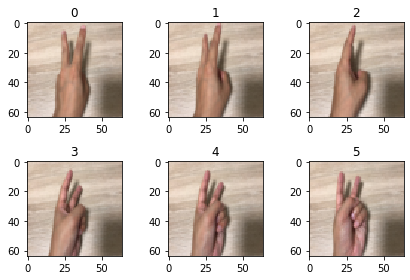

In [ ]:
image_numb = 6 # 3の倍数を指定してください
for i in range(0, image_numb):
  ax = plt.subplot(image_numb / 3, 3, i + 1)
  plt.tight_layout()
  ax.set_title(str(i))
  plt.imshow(dataset_train[i][0].numpy().transpose((1, 2, 0)))

## ラベルファイルの作成

学習するファイルのラベルを作成します

必要なライブラリをインポートします

In [ ]:
import sys
import os
import shutil

データを保存する場所を指定します。

今後、ラベルデータやモデルデータなどは以下のディレクトリに保存されます。

In [ ]:
backup_dir = './model'

ラベルデータを作成します（最後に表示される class numberが画像の種類の数です）

In [ ]:
labels = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
labels.sort()

if os.path.exists(backup_dir):
    shutil.rmtree(backup_dir)

os.makedirs(backup_dir)

with open(backup_dir + '/labels.txt','w') as f:
    for label in labels:
        f.write(label+"\n")

NUM_CLASSES = len(labels)
print("class number=" + str(NUM_CLASSES))

class number=3


ラベルを確認します。ラベル名（choki, gu, pa）が並んでいればOKです

In [ ]:
!cat ./model/labels.txt

choki
gu
pa


## モデルの作成

ハイパーパラメータを設定します。

TensorFlow（Keras）のときとは学習率が大きく異なるため注意して下さい。

In [ ]:
# 学習率
LEARNING_RATE = 1.0
# エポック（世代数）
EPOCHS = 20
# バッチサイズ
BATCH_SIZE = 4

学習用のデータをデータセットからロードするデータローダーを作成します。これにより、データセットからバッチと呼ばれるデータのまとまりで、データをロードすることができます。

- batch_size: バッチサイズ
- shuffle: シャッフルするか
- num_workers: データをロードするコア数

In [ ]:
train_dataloader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=1)
test_dataloader = torch.utils.data.DataLoader(dataset_val,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=1)

モデルを作成します。ポイントとなる1層目の畳み込み層のConv2dの定義は以下です。
```
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
```

今回扱うRGB画像は、入力チャンネルがR,G,Bの3チャンネル。出力チャンネルは64, カーネルサイズは 3x3、padding=1とします。paddingを1としているのは、畳み込み前後で画像のサイズを変えないためです。

具体的には以下となります。

```
nn.Conv2d(3, 32, (3, 3), 1, 1)
```

またfc層への接続は、注意が必要です。

fc層(fc1) の入力は以下となります。

```
チャネル数 * イメージマップのサイズ
```

チャネル数は、conv2層の出力 64 となります。また、イメージマップのサイズは、最初 64x64だったものが、CNN層、プーリング層によりサイズが変わるため計算が必要です。

CNNの場合は、カーネルサイズ、パディングによって変わりますが、今回は入力と出力でサイズが変わらないように調整してあります。

マックスプーリングは、2x2で実施しているので半分になります。よって 32x32 がイメージマップのサイズとなります。

全結合層へ繋げるための1次元へ展開は、x.viewを使います。-1を引数とすることで、self.num_flat_features(x)の値から自動的に値が決まります。

```
x = x.view(-1, self.num_flat_features(x))
```

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, (3, 3), 1, 1)
    self.conv2 = nn.Conv2d(32, 64, (3, 3), 1, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(64 * 32 * 32, 128) # 32 = 64(IMAGE_SIZE) / 2
    self.fc2 = nn.Linear(128, NUM_CLASSES)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

モデルを定義して、確認します。

最初の1行は、GPU(CUDA)が使えるかを判断しています。

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


パラメータの確認をします

In [ ]:
#model.parameters()をリストに型変換することでパラメータを取り出せる
params=list(model.parameters())
#len(params)はパラメータの種類の数
print(len(params))
#conv1の重みのサイズを確認する
print(params[0].size())
#conv2の重みのサイズを確認する
print(params[2].size())

8
torch.Size([32, 3, 3, 3])
torch.Size([64, 32, 3, 3])


ニューラルネットワークのテスト。ニューラルネットの入力に合わせた、教師データと同じサイズのランダムな画像をネットワークに入力して出力を確認します。

`個数, チャネル数, 画像サイズ, 画像サイズ`

デバイス(GPU or CPU)に応じた変換(`.to(device)`)が必要なことに注意しましょう。

最終的な出力が、3つ（ラベルの数）になっていることを確認します。

In [ ]:
input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
input = input.to(device)
out = model(input)
print(out)

tensor([[-1.0996, -0.9474, -1.2756]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)


最適化方法を定義

In [ ]:
from torch import optim
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)

AIモデルの学習を行います

In [ ]:
def train(model, device, train_dataloader, optimizer):
  train_loss = 0

  model.train()
  for batch_idx, (data, target) in enumerate(train_dataloader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    train_loss += loss.item()

    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)

  return train_loss

In [ ]:
def test(model, device, test_dataloader):
  model.eval()
  val_loss = 0
  val_acc = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_dataloader):
      data, target = data.to(device), target.to(device)
      output = model(data)
      val_loss += F.nll_loss(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
      total += target.size(0)

  val_loss = val_loss / len(test_dataloader)
  val_acc = correct / total

  return val_loss, val_acc

In [ ]:
train_loss_list = []

val_loss_list = []
val_acc_list = []

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, device, train_dataloader, optimizer)
  val_loss, val_acc = test(model, device, test_dataloader)

  train_loss_list.append(train_loss)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)

  print('epoch: {:d}'.format(epoch))
  print('val_loss: {:.4f}, val_acc: {:.4f}'.format(100. * val_loss, val_acc))

epoch: 1
val_loss: 106.8066, val_acc: 0.2931
epoch: 2
val_loss: 95.9504, val_acc: 0.4138
epoch: 3
val_loss: 83.1520, val_acc: 0.5862
epoch: 4
val_loss: 78.9655, val_acc: 0.5517
epoch: 5
val_loss: 83.5023, val_acc: 0.5000
epoch: 6
val_loss: 61.4045, val_acc: 0.6897
epoch: 7
val_loss: 70.9731, val_acc: 0.7759
epoch: 8
val_loss: 49.5207, val_acc: 0.8276
epoch: 9
val_loss: 25.8795, val_acc: 0.8966
epoch: 10
val_loss: 29.9863, val_acc: 0.8966
epoch: 11
val_loss: 35.5723, val_acc: 0.8793
epoch: 12
val_loss: 32.1600, val_acc: 0.9138
epoch: 13
val_loss: 33.2239, val_acc: 0.8103
epoch: 14
val_loss: 27.1605, val_acc: 0.9138
epoch: 15
val_loss: 18.5712, val_acc: 0.9138
epoch: 16
val_loss: 22.4323, val_acc: 0.9138
epoch: 17
val_loss: 64.2448, val_acc: 0.8793
epoch: 18
val_loss: 33.9559, val_acc: 0.9310
epoch: 19
val_loss: 25.3236, val_acc: 0.9483
epoch: 20
val_loss: 37.3268, val_acc: 0.9310


## 学習結果の可視化

lossを確認します。lossは正解との差を意味するモデルを評価するための指標で、低いほど良い値となります。

AIモデルは、この値が低くなるように学習を進めます。

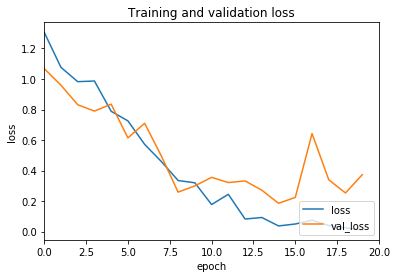

In [ ]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim([0.0, EPOCHS])
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.show()

acc（精度）を確認します。accが訓練データでの精度で、この値が高いほど良い性能を意味します。
例えば0.5だと50%の正解率ということになります。

val_accというのが訓練に使っていないテストデータを使っての精度です。  
いわゆる、本当の精度と言われるものは、val_accの方となります。

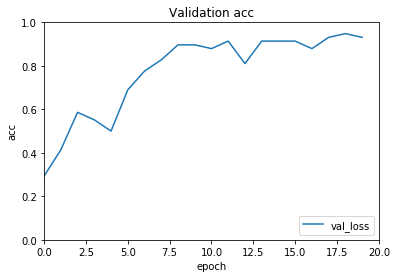

In [ ]:
plt.plot(val_acc_list)
plt.title('Validation acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.xlim([0.0, EPOCHS])
plt.ylim([0.0, 1.0])
plt.legend(['val_loss'], loc='lower right')
plt.show()

## 学習させたモデルを使った推定

学習させたモデルを使って、画像の推定を行います

In [ ]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    fig = plt.figure(figsize=(16, num_images))

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            _, pred = torch.max(output, 1)

            for n in range(data.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                color = 'green' if pred[n] == target[n] else 'red'
                ax.set_title('predicted: {} , label: {}'.format(labels[pred[n]], labels[target[n]]), color=color)
                plt.imshow(data.cpu().data[n].numpy().transpose((1, 2, 0)))
                if images_so_far == num_images:
                    return

<Figure size 432x288 with 0 Axes>

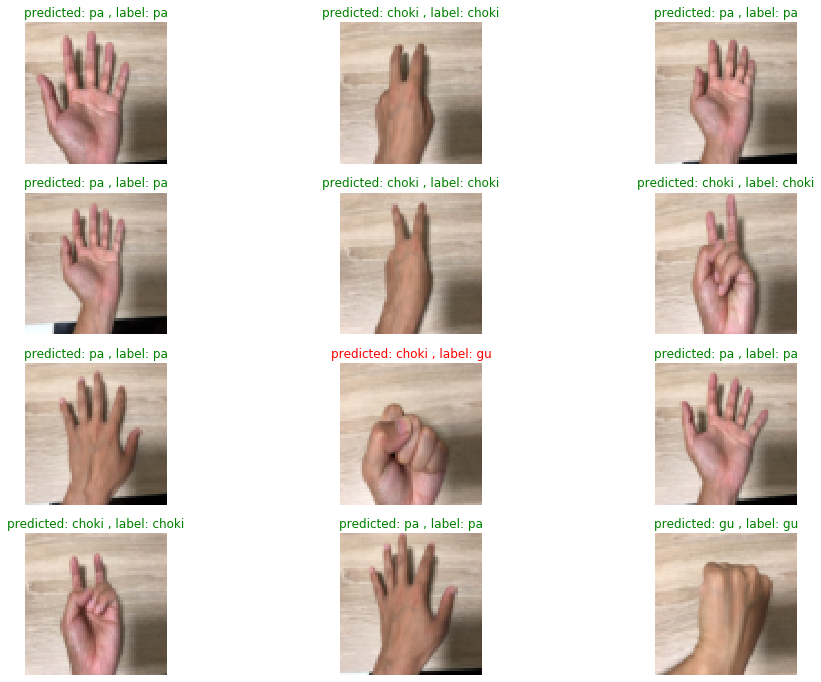

In [ ]:
visualize_model(model, num_images=12)

## 混合行列(Confusion Matrix)の可視化

https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial

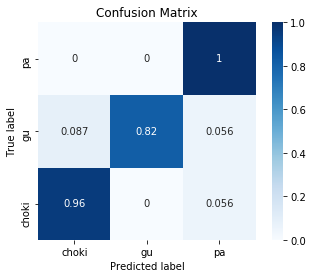

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0, dtype=torch.long, device='cpu')
lbllist=torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_dataloader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, pred = torch.max(output, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,pred.view(-1).cpu()])
        lbllist=torch.cat([lbllist,target.view(-1).cpu()])

# Confusion matrix
cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
cm = cm/cm.sum(1)

sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Blues,
            xticklabels=labels,
            yticklabels=labels)

plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xlim([0.0, NUM_CLASSES])
plt.ylim([0.0, NUM_CLASSES])
plt.show()

## 学習モデルの保存とダウンロード

学習モデルを保存します。また、Google Colaboratory上のファイルは、自動的に消えてしまうのでモデルをローカルにダウンロードします。

最初にモデルを保存します。

In [ ]:
model_path = backup_dir + 'model.pth'
torch.save(model.state_dict(), model_path)

モデルをダウンロードします。

In [ ]:
from google.colab import files
files.download(model_path)

## まとめ

ここまでで、学習から推論は完了です。

## 参考リンク

以下は多くを参考にした情報です。

前処理（データセット・データローダー）
- https://sonaeru-blog.com/pytorch-dataset/
- http://kaga100man.com/2019/01/09/post-89/
- https://qiita.com/takurooo/items/e4c91c5d78059f92e76d
- https://discuss.pytorch.org/t/questions-about-imagefolder/774/6

自作データセットの学習
- http://robonchu.hatenablog.com/entry/2017/10/23/173317

ニューラルネットワーク・学習
- https://github.com/pytorch/examples/blob/master/mnist/main.py
- http://aidiary.hatenablog.com/entry/20180205/1517832760
- https://pytorch.org/docs/stable/nn.html
- https://blog.shikoan.com/pytorch-convtranspose2d/
- https://www.hellocybernetics.tech/entry/2017/10/20/025702
- https://www.hellocybernetics.tech/entry/2018/02/20/182906
- https://www.sambaiz.net/article/205/
- https://www.procrasist.com/entry/19-pytorch
- https://qiita.com/mckeeeen/items/e255b4ac1efba88d0ca1
- https://tips-memo.com/python-pytorch-3
- https://qiita.com/kamata1729/items/7adaead883566e3043b5

認識結果の可視化
- http://torch.classcat.com/2018/04/29/pytorch-tutorial-transfer-learning/

つまづきポイント
- https://qiita.com/takurooo/items/e356dfdeec768d8f7146

## 参考書籍
つくりながら学ぶ！PyTorchによる発展ディープラーニング